# WeightWatcher ResNet

https://calculationconsulting.com

### Analysis of pyTorch 

In [1]:
# Suppress the powerlaw package warnings
# "powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide"
# "powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide"
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [2]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### Import WeightWatcher

set custom Logging at WARN Level

In [3]:
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
logger.setLevel(logging.WARN)

import weightwatcher as ww
import torchvision.models as models

ww.__version__


Using TensorFlow backend.


'0.2.2'

### Create all models now

In [34]:

series_name = 'ResNet'
all_names = [ 'resnet18', 'resnet34', 'resnet50', 'resnet101','resnet152']

colors =    ['blue',     'cyan',   'darkgreen', 'goldenrod','red']

In [4]:


all_models = []
all_models.append(models.resnet18(pretrained=True))
all_models.append(models.resnet34(pretrained=True))
all_models.append(models.resnet50(pretrained=True))
all_models.append(models.resnet101(pretrained=True))
all_models.append(models.resnet152(pretrained=True))




### Get reported accuracies from pytorch website

https://pytorch.org/docs/stable/torchvision/models.html

<pre>
<table class="docutils align-default">
<colgroup>
<col style="width: 55%" />
<col style="width: 22%" />
<col style="width: 22%" />
</colgroup>
<thead>
<thead>
<tr class="row-odd"><th class="head"><p>Network</p></th>
<th class="head"><p>Top-1 error</p></th>
<th class="head"><p>Top-5 error</p></th>
</tr>
</thead>
<tbody>

<tr class="row-odd"><td><p>ResNet-18</p></td>
<td><p>30.24</p></td>
<td><p>10.92</p></td>
</tr>
<tr class="row-even"><td><p>ResNet-34</p></td>
<td><p>26.70</p></td>
<td><p>8.58</p></td>
</tr>
<tr class="row-odd"><td><p>ResNet-50</p></td>
<td><p>23.85</p></td>
<td><p>7.13</p></td>
</tr>
<tr class="row-even"><td><p>ResNet-101</p></td>
<td><p>22.63</p></td>
<td><p>6.44</p></td>
</tr>
<tr class="row-odd"><td><p>ResNet-152</p></td>
<td><p>21.69</p></td>
<td><p>5.94</p></td>
</tr>

</tbody>
</table>
</pre>

In [5]:
top1_errors= {
    
    "resnet18": 30.24,
    "resnet34": 26.70,
    "resnet50": 23.85,
    "resnet101": 22.63,
    "resnet152": 21.69 

}

In [6]:
top5_errors= {
    
    "resnet18": 10.92,
    "resnet34": 8.58,
    "resnet50": 7.13,
    "resnet101": 6.44,
    "resnet152": 5.94    

}

## Run WeightWatcher, collect summary and details (as dataframes) for all models

In [17]:
all_details = []
all_summaries = []
for im, name in enumerate(all_names):
    watcher = ww.WeightWatcher(model=all_models[im])
    results = watcher.analyze(alphas=True, softranks=True, spectralnorms=True, mp_fit=True)

    summary =  watcher.get_summary()
    all_summaries.append(summary)
    details  = watcher.get_details(results=results)
    details.drop(columns=['slice', 'slice_count'], inplace=True)
    details.dropna(inplace=True)
    details['NxM'] = pd.to_numeric(details.N * details.M)

    all_details.append(details)

2019-12-26 21:29:15,453 INFO 

python      version 3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
numpy       version 1.16.4
tensforflow version 1.13.1
keras       version 2.2.4
INFO:weightwatcher.weightwatcher:

python      version 3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
numpy       version 1.16.4
tensforflow version 1.13.1
keras       version 2.2.4
2019-12-26 21:29:15,455 INFO Analyzing model
INFO:weightwatcher.weightwatcher:Analyzing model
2019-12-26 21:30:27,289 INFO ### Printing results ###
INFO:weightwatcher.weightwatcher:### Printing results ###
2019-12-26 21:30:30,251 INFO Norm: min: 2.1772398948669434, max: 49.700775146484375, avg: 5.529301643371582
INFO:weightwatcher.weightwatcher:Norm: min: 2.1772398948669434, max: 49.700775146484375, avg: 5.529301643371582
2019-12-26 21:30:30,252 INFO Norm compound: min: 2.7893476486206055, max: 49.700775146484375, avg: 7.832644462585449
INFO:weightwatcher.weightwatcher:

INFO:weightwatcher.weightwatcher:Alpha: min: 1.5558699203828597, max: 8.223250109935574, avg: 3.3532789820483138
2019-12-26 21:30:33,276 INFO Alpha compound: min: 1.9172953391902883, max: 6.425603222855434, avg: 3.313175190121174
INFO:weightwatcher.weightwatcher:Alpha compound: min: 1.9172953391902883, max: 6.425603222855434, avg: 3.313175190121174
2019-12-26 21:30:33,277 INFO Alpha Weighted: min: -1.735479202366478, max: 6.198481393660566, avg: 0.6106765159701216
INFO:weightwatcher.weightwatcher:Alpha Weighted: min: -1.735479202366478, max: 6.198481393660566, avg: 0.6106765159701216
2019-12-26 21:30:33,278 INFO Alpha Weighted compound: min: -0.4932892978665104, max: 6.198481393660566, avg: 0.958536395694151
INFO:weightwatcher.weightwatcher:Alpha Weighted compound: min: -0.4932892978665104, max: 6.198481393660566, avg: 0.958536395694151
2019-12-26 21:30:33,278 INFO Spectral Norm: min: 0.18535013496875763, max: 71.3998031616211, avg: 2.349897861480713
INFO:weightwatcher.weightwatcher:Sp

2019-12-26 21:33:03,982 INFO Spectral Norm compound: min: 0.38105249404907227, max: 58.11369323730469, avg: 2.638397693634033
INFO:weightwatcher.weightwatcher:Spectral Norm compound: min: 0.38105249404907227, max: 58.11369323730469, avg: 2.638397693634033
2019-12-26 21:33:03,983 INFO Softrank: min: 3.9005338109364946, max: 106.91584199119443, avg: 22.617846148393223
INFO:weightwatcher.weightwatcher:Softrank: min: 3.9005338109364946, max: 106.91584199119443, avg: 22.617846148393223
2019-12-26 21:33:03,984 INFO Softrank compound: min: 6.265255384131034, max: 89.72820450963354, avg: 23.00507229676183
INFO:weightwatcher.weightwatcher:Softrank compound: min: 6.265255384131034, max: 89.72820450963354, avg: 23.00507229676183
2019-12-26 21:33:03,986 INFO Softrank Log: min: 0.5911240468417939, max: 2.029042060490469, avg: 1.2593056831844414
INFO:weightwatcher.weightwatcher:Softrank Log: min: 0.5911240468417939, max: 2.029042060490469, avg: 1.2593056831844414
2019-12-26 21:33:03,988 INFO Softran

INFO:weightwatcher.weightwatcher:Softrank Log Ratio compound: min: -87.25331314715724, max: 133.85448367514834, avg: 6.345387584418537
2019-12-26 21:33:10,124 INFO Marchenko-Pastur (MP) fit sigma: min: 0.3545312500000001, max: 1.00673828125, avg: 0.8365824911039171
INFO:weightwatcher.weightwatcher:Marchenko-Pastur (MP) fit sigma: min: 0.3545312500000001, max: 1.00673828125, avg: 0.8365824911039171
2019-12-26 21:33:10,126 INFO Marchenko-Pastur (MP) fit sigma compound: min: 0.3978689236111112, max: 0.9999975585937502, avg: 0.8207157766083142
INFO:weightwatcher.weightwatcher:Marchenko-Pastur (MP) fit sigma compound: min: 0.3978689236111112, max: 0.9999975585937502, avg: 0.8207157766083142
2019-12-26 21:33:10,126 INFO Number of spikes per MP fit: min: 0, max: 217, avg: 1.5616438356164384
INFO:weightwatcher.weightwatcher:Number of spikes per MP fit: min: 0, max: 217, avg: 1.5616438356164384
2019-12-26 21:33:10,127 INFO Number of spikes per MP fit compound: min: 0.0, max: 217.0, avg: 7.97530

INFO:weightwatcher.weightwatcher:aka, percent_mass, Number of spikes / total number of evals: min: 0.0, max: 0.4603174603174603, avg: 0.04730254151309002
2019-12-26 21:35:03,370 INFO aka, percent_mass, Number of spikes / total number of evals compound: min: 0.0, max: 0.4603174603174603, avg: 0.16154264177111874
INFO:weightwatcher.weightwatcher:aka, percent_mass, Number of spikes / total number of evals compound: min: 0.0, max: 0.4603174603174603, avg: 0.16154264177111874
2019-12-26 21:35:03,371 INFO Softrank for MP fit: min: 0.023655835511494423, max: 11.876395480527572, avg: 3.612091938658095
INFO:weightwatcher.weightwatcher:Softrank for MP fit: min: 0.023655835511494423, max: 11.876395480527572, avg: 3.612091938658095
2019-12-26 21:35:03,372 INFO Softrank for MP fit compound: min: 0.023655835511494423, max: 7.0267232225550496, avg: 1.520936317664898
INFO:weightwatcher.weightwatcher:Softrank for MP fit compound: min: 0.023655835511494423, max: 7.0267232225550496, avg: 1.52093631766489

INFO:weightwatcher.weightwatcher:

python      version 3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
numpy       version 1.16.4
tensforflow version 1.13.1
keras       version 2.2.4
2019-12-26 21:35:08,092 INFO Analyzing model
INFO:weightwatcher.weightwatcher:Analyzing model
2019-12-26 21:38:31,369 INFO ### Printing results ###
INFO:weightwatcher.weightwatcher:### Printing results ###
2019-12-26 21:38:40,115 INFO Norm: min: 0.5827633142471313, max: 46.044219970703125, avg: 3.5871057510375977
INFO:weightwatcher.weightwatcher:Norm: min: 0.5827633142471313, max: 46.044219970703125, avg: 3.5871057510375977
2019-12-26 21:38:40,116 INFO Norm compound: min: 0.8463587164878845, max: 46.044219970703125, avg: 5.906709671020508
INFO:weightwatcher.weightwatcher:Norm compound: min: 0.8463587164878845, max: 46.044219970703125, avg: 5.906709671020508
2019-12-26 21:38:40,117 INFO LogNorm: min: -0.23450779914855957, max: 1.663175106048584, avg: 0.47187304496765137
INFO:w

2019-12-26 21:38:48,838 INFO Alpha compound: min: 1.288869563208864, max: 10.837061959294255, avg: 3.3238913918917317
INFO:weightwatcher.weightwatcher:Alpha compound: min: 1.288869563208864, max: 10.837061959294255, avg: 3.3238913918917317
2019-12-26 21:38:48,839 INFO Alpha Weighted: min: -9.906527185251477, max: 6.0592084616914255, avg: -0.6164704260939629
INFO:weightwatcher.weightwatcher:Alpha Weighted: min: -9.906527185251477, max: 6.0592084616914255, avg: -0.6164704260939629
2019-12-26 21:38:48,841 INFO Alpha Weighted compound: min: -3.7153152590865384, max: 6.0592084616914255, avg: 0.30738111858081596
INFO:weightwatcher.weightwatcher:Alpha Weighted compound: min: -3.7153152590865384, max: 6.0592084616914255, avg: 0.30738111858081596
2019-12-26 21:38:48,842 INFO Spectral Norm: min: 0.025768278166651726, max: 49.8695182800293, avg: 1.0526798963546753
INFO:weightwatcher.weightwatcher:Spectral Norm: min: 0.025768278166651726, max: 49.8695182800293, avg: 1.0526798963546753
2019-12-26 2

INFO:weightwatcher.weightwatcher:Spectral Norm compound: min: 0.2520211935043335, max: 48.75481414794922, avg: 1.537049651145935
2019-12-26 21:43:34,931 INFO Softrank: min: 2.2992474837431214, max: 98.49819249615005, avg: 17.4049847668072
INFO:weightwatcher.weightwatcher:Softrank: min: 2.2992474837431214, max: 98.49819249615005, avg: 17.4049847668072
2019-12-26 21:43:34,932 INFO Softrank compound: min: 2.703566104769748, max: 98.49819249615005, avg: 22.562603526409276
INFO:weightwatcher.weightwatcher:Softrank compound: min: 2.703566104769748, max: 98.49819249615005, avg: 22.562603526409276
2019-12-26 21:43:34,934 INFO Softrank Log: min: 0.3615857198727338, max: 1.9934282609935454, avg: 1.1342460662040867
INFO:weightwatcher.weightwatcher:Softrank Log: min: 0.3615857198727338, max: 1.9934282609935454, avg: 1.1342460662040867
2019-12-26 21:43:34,935 INFO Softrank Log compound: min: 0.4298078188748186, max: 1.9934282609935454, avg: 1.2625866063824769
INFO:weightwatcher.weightwatcher:Softra

INFO:weightwatcher.weightwatcher:Marchenko-Pastur (MP) fit sigma: min: 0.284443359375, max: 1.0867187500000004, avg: 0.7714098923141892
2019-12-26 21:43:48,800 INFO Marchenko-Pastur (MP) fit sigma compound: min: 0.284443359375, max: 1.0470703125000003, avg: 0.5238230776769714
INFO:weightwatcher.weightwatcher:Marchenko-Pastur (MP) fit sigma compound: min: 0.284443359375, max: 1.0470703125000003, avg: 0.5238230776769714
2019-12-26 21:43:48,801 INFO Number of spikes per MP fit: min: 0, max: 308, avg: 7.596396396396396
INFO:weightwatcher.weightwatcher:Number of spikes per MP fit: min: 0, max: 308, avg: 7.596396396396396
2019-12-26 21:43:48,803 INFO Number of spikes per MP fit compound: min: 0.0, max: 308.0, avg: 27.2
INFO:weightwatcher.weightwatcher:Number of spikes per MP fit compound: min: 0.0, max: 308.0, avg: 27.2
2019-12-26 21:43:48,804 INFO aka, percent_mass, Number of spikes / total number of evals: min: 0.0, max: 0.49206349206349204, avg: 0.02940427364799917
INFO:weightwatcher.weig

In [19]:
plt.rcParams.update({'font.size': 16})
from pylab import rcParams
rcParams['figure.figsize'] = 10,10

In [28]:
summary

{'norm': 5.5293016,
 'norm_compound': 7.8326445,
 'lognorm': 0.6898473,
 'lognorm_compound': 0.7606753,
 'alpha': 3.3532789820483138,
 'alpha_compound': 3.313175190121174,
 'alpha_weighted': 0.6106765159701216,
 'alpha_weighted_compound': 0.958536395694151,
 'spectralnorm': 2.3498979,
 'spectralnorm_compound': 5.3375053,
 'softrank': 18.904574346978933,
 'softrank_compound': 20.14694494823168,
 'softranklog': 1.1920792894892904,
 'softranklog_compound': 1.2244703684761524,
 'softranklogratio': 1.6301506349009565,
 'softranklogratio_compound': 2.1100829928376537,
 'sigma_mp': 0.8333819415118244,
 'sigma_mp_compound': 0.8050422092013889,
 'numofSpikes': 3.675675675675676,
 'numofSpikes_compound': 15.777777777777777,
 'ratio_numofSpikes': 0.019168015828062653,
 'ratio_numofSpikes_compound': 0.055684550757146935,
 'softrank_mp': 2.1459826968683022,
 'softrank_mp_compound': 1.8127794458133337,
 'logpnorm': 0.9977825208827056,
 'logpnorm_compound': 1.3885149203908607}

## Metrics vs Test Accuracy

In [125]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [147]:

def plot_test_accuracy(metric, xlabel, title):
    """Create plot of Metric vs Reported Test Accuracy, and run Linear Regression"""
    num = len(all_names)
    xs, ys = np.empty(num), np.empty(num)
    for im, modelname in enumerate(all_names):    

        summary = all_summaries[im]
        x = summary[metric]
        xs[im] = x

        error = top1_errors[modelname]
        y = 100.0-error
        ys[im] = y

        label = modelname
        plt.scatter(x, y, label=label)


    xs = xs.reshape(-1,1)
    ys = ys.reshape(-1,1)
    regr = linear_model.LinearRegression()
    regr.fit(xs, ys)
    y_pred = regr.predict(xs)
    plt.plot(xs, y_pred, color='red', linewidth=1)

    rmse = np.sqrt(metrics.mean_squared_error(ys, y_pred))
    r2 = metrics.r2_score(ys, y_pred)
    title2 = "RMSE: {0:.2}   R2: {0:.2}".format(rmse, r2)
    
    plt.legend()
    plt.title(r"Test Accuracy vs "+title+"\n"+title2)
    plt.ylabel(r"Test Accuracy")
    plt.xlabel(xlabel);


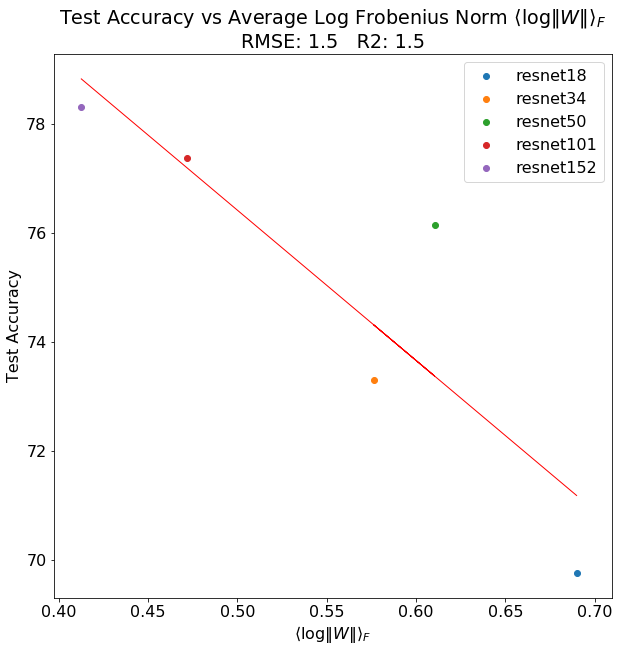

In [148]:
metric = "lognorm"
xlabel = r"$\langle\log\Vert W\Vert\rangle_{F}$"
title = "Average Log Frobenius Norm "+xlabel

plot_test_accuracy(metric, xlabel, title)


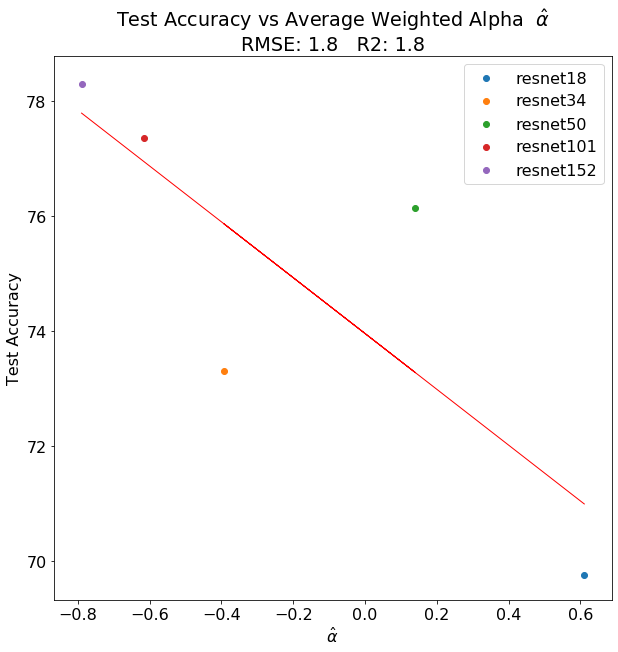

In [149]:
metric = "alpha_weighted"
xlabel = r"$\hat{\alpha}$"
title = "Average Weighted Alpha  "+xlabel

plot_test_accuracy(metric, xlabel, title)

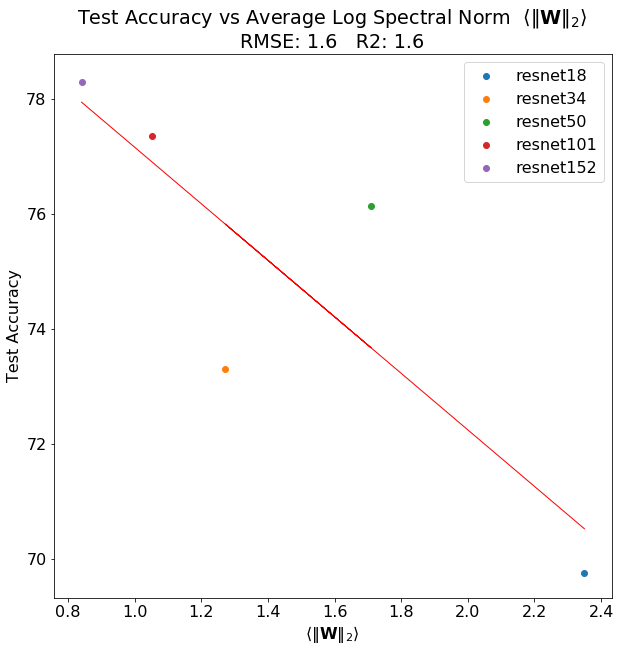

In [154]:
metric = "spectralnorm"
xlabel = r"$\langle\Vert\mathbf{W}\Vert_{2}\rangle$"
title = "Average Log Spectral Norm  "+xlabel

plot_test_accuracy(metric, xlabel, title)

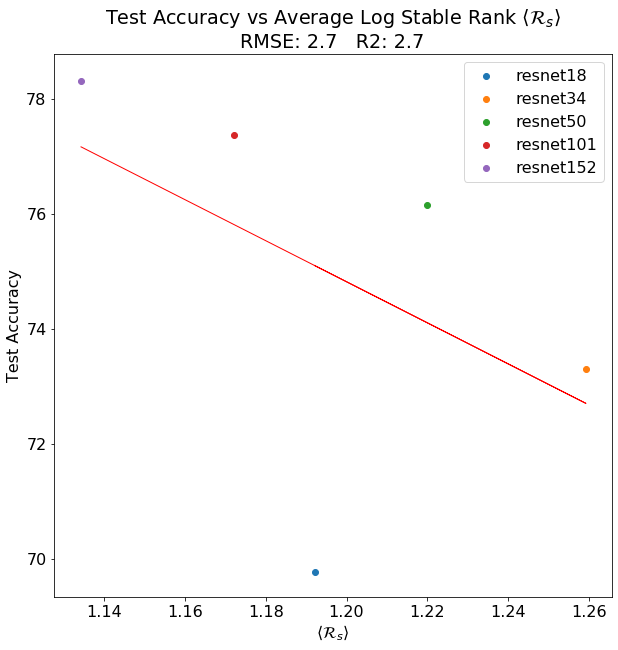

In [153]:
metric = "softranklog"
xlabel = r"$\langle\mathcal{R}_{s}\rangle$"
title = "Average Log Stable Rank "+xlabel

plot_test_accuracy(metric, xlabel, title)

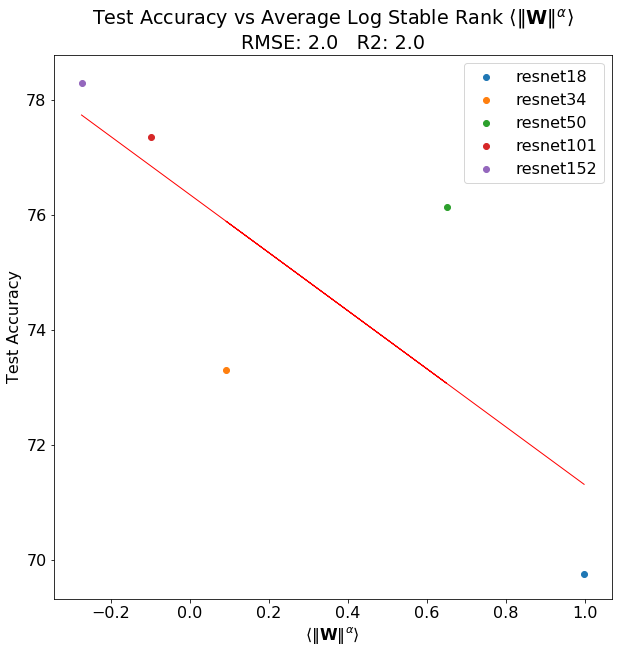

In [152]:
metric = "logpnorm"
xlabel = r"$\langle\Vert\mathbf{W}\Vert^{\alpha}\rangle$"
title = "Average Log Stable Rank "+xlabel

plot_test_accuracy(metric, xlabel, title)

## Histogram of metrics for all layers

Text(0.5, 0, 'alpha')

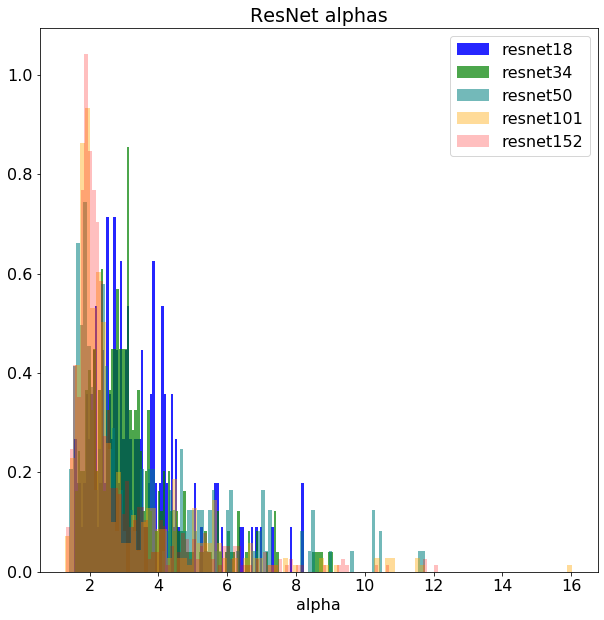

In [36]:
colors = ['blue', 'green', 'teal', 'orange', 'red']
transparency = 1.0
for im, details in enumerate(all_details):
    alphas = details.alpha.to_numpy()
    transparency -= 0.15
    
    plt.hist(alphas, bins=100, label=all_names[im], alpha=transparency, color=colors[im], density=True)
plt.legend()
plt.title("{} alphas".format(series_name))
plt.xlabel("alpha")

Text(0.5, 0, 'alpha')

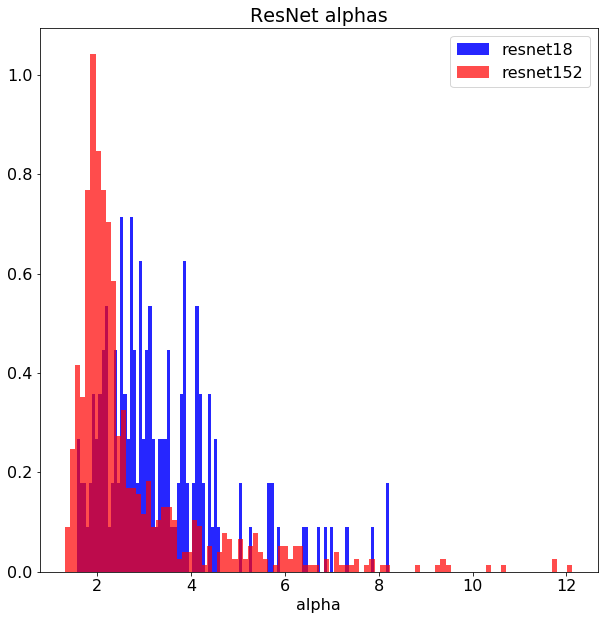

In [37]:
colors = ['blue', 'green', 'teal', 'orange', 'red']
transparency = 1.0
for im, details in enumerate(all_details):
    if im==0 or im == 4:
        alphas = details.alpha.to_numpy()
        transparency -= 0.15

        plt.hist(alphas, bins=100, label=all_names[im], alpha=transparency, color=colors[im], density=True)
plt.legend()
plt.title("{} alphas".format(series_name))
plt.xlabel("alpha")

Text(0.5, 0, 'log Frobenius Norm')

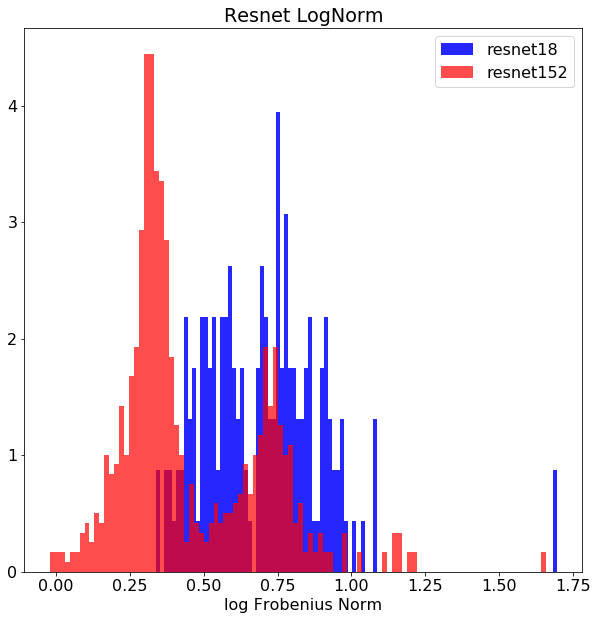

In [26]:
colors = ['blue', 'green', 'teal', 'orange', 'red']
transparency = 1.0
for im, details in enumerate(all_details):
    if im==0 or im == 4:
        logNorm = details.lognorm.to_numpy()
        transparency -= 0.15

        plt.hist(logNorm, bins=100, label=all_names[im], alpha=transparency, color=colors[im], density=True)
plt.legend()
plt.title("Resnet LogNorm")
plt.xlabel("log Frobenius Norm")

Text(0.5, 0, 'log Stable Rank')

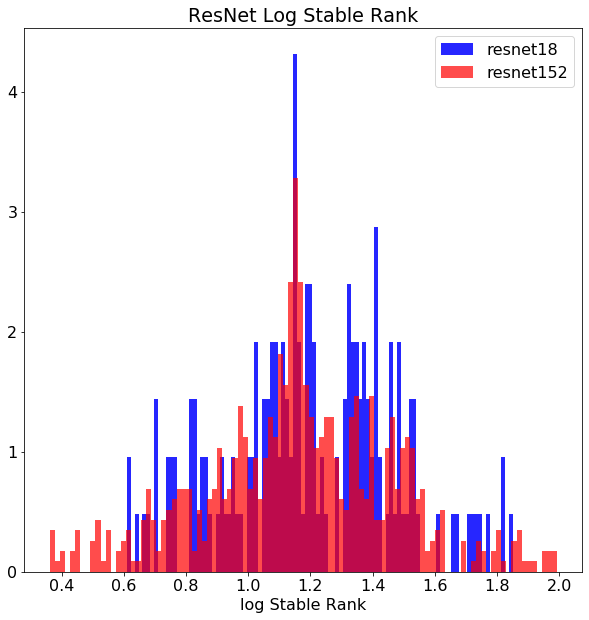

In [38]:
colors = ['blue', 'green', 'teal', 'orange', 'red']
transparency = 1.0
for im, details in enumerate(all_details):
    if im==0 or im == 4:
        logNorm = details.softranklog.to_numpy()
        transparency -= 0.15

        plt.hist(logNorm, bins=100, label=all_names[im], alpha=transparency, color=colors[im], density=True)
plt.legend()
plt.title("{} Log Stable Rank".format(series_name))
plt.xlabel("log Stable Rank")

In [30]:
all_details[0].head()

,layer_type,N,M,level,comment,norm,lognorm,alpha,alpha_weighted,spectralnorm,softrank,softranklog,softranklogratio,sigma_mp,numofSpikes,ratio_numofSpikes,softrank_mp,logpnorm,NxM
layer_id,,,,,,,,,,,,,,,,,,,
7,CONV2D,64,64,LEVEL.SLICE,Slice level,2.50896,0.399494,2.08593,0.394013,1.54487,4.07471,0.610097,4.22988,0.964453,0,0,2.40841,0.638994,4096
7,CONV2D,64,64,LEVEL.SLICE,Slice level,3.11053,0.492834,1.64773,0.259975,1.43806,6.72806,0.82789,6.24719,0.960352,0,0,2.56533,0.871293,4096
7,CONV2D,64,64,LEVEL.SLICE,Slice level,2.56493,0.409076,2.049,0.229971,1.2949,5.08061,0.705916,7.2896,0.950293,0,0,2.78959,0.609182,4096
7,CONV2D,64,64,LEVEL.SLICE,Slice level,3.24392,0.51107,1.61268,0.276545,1.48416,7.0902,0.850658,5.96063,0.961426,0,0,2.49121,0.928379,4096
7,CONV2D,64,64,LEVEL.SLICE,Slice level,5.73808,0.758766,1.85414,1.67803,8.03563,4.09744,0.612512,1.67679,1.00576,3,0.047619,0.503536,2.00907,4096


Text(0.5, 0, 'Log Spectral Norm')

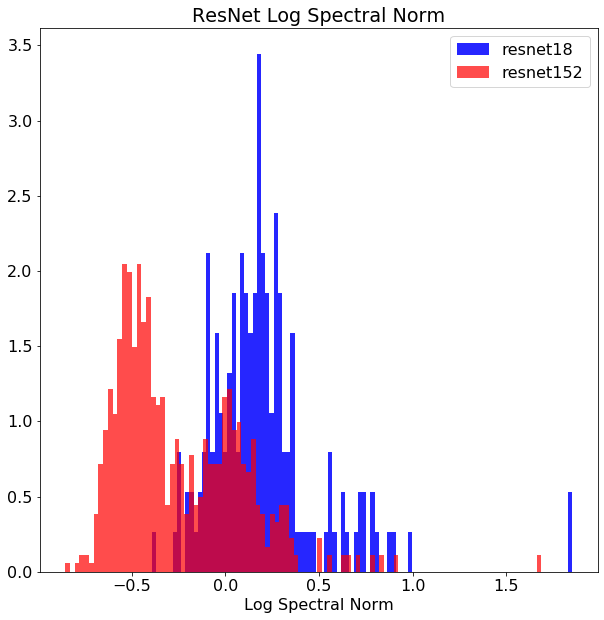

In [39]:
colors = ['blue', 'green', 'teal', 'orange', 'red']
transparency = 1.0
for im, details in enumerate(all_details):
    if im==0 or im == 4:
        logSpectralNorm = details.spectralnorm.to_numpy()
        logSpectralNorm = np.log10(np.array(logSpectralNorm+0.000001, dtype=np.float))
        transparency -= 0.15

        plt.hist(logSpectralNorm, bins=100, label=all_names[im], alpha=transparency, color=colors[im], density=True)
plt.legend()
plt.title("{} Log Spectral Norm".format(series_name))
plt.xlabel("Log Spectral Norm")

In [40]:
colors = ['blue', 'green', 'teal', 'orange', 'red']
transparency = 1.0
for im, details in enumerate(all_details):
    if im==0 or im == 4:
        MpSoftRank = details.softrank_mp.to_numpy()
        transparency -= 0.15

        plt.hist(MpSoftRank, bins=100, label=all_names[im], alpha=transparency, color=colors[im], density=True)
plt.legend()
plt.title("{} MP Soft Rank"..format(series_name))
plt.xlabel("MP Soft Rank")

SyntaxError: invalid syntax (<ipython-input-40-b33375286d2c>, line 10)

Text(0.5, 0, 'Log pNorm')

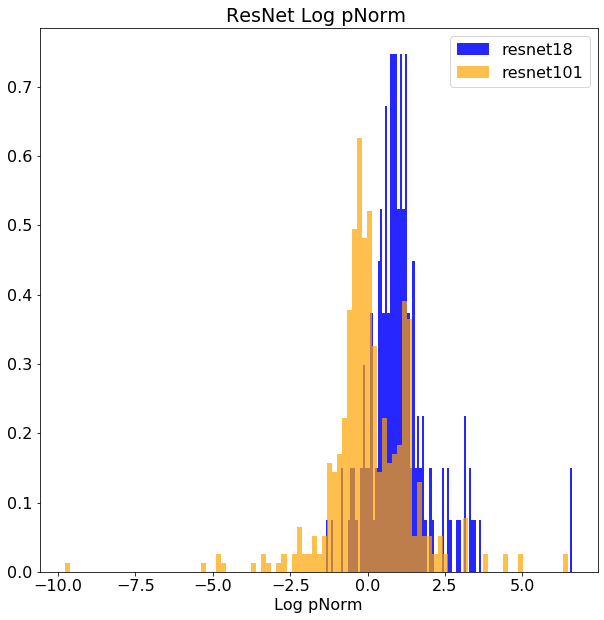

In [41]:
transparency = 1.0
for im, details in enumerate(all_details):
    if im == 0 or im == len(all_details)-2:
        
        metric = details.logpnorm.to_numpy()

        transparency -= 0.15

        plt.hist(metric, bins=100, label=all_names[im], alpha=transparency, color=colors[im], density=True)
plt.legend()
plt.title(r"{} Log pNorm ".format(series_name))
plt.xlabel(r"Log pNorm")   

## Metrics as a function of depth